## Create data for unit testing of `solardatatools.signal_decompositions`
## Test module `test_signal_decompositions`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import random

from utils import plot_decomp
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

## `l2_l1d1_l2d2p365`

Components:
- l2: gaussian noise, sum-of-squares small or l2-norm squared
- l1d1: piecewise constant heuristic, l1-norm of first order differences
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests"
- test_l2_l1d1_l2d2p365_default
- test_l2_l1d1_l2d2p365_tv_weights
- test_l2_l1d1_l2d2p365_residual_weights
- test_l2_l1d1_l2d2p365_transition
- test_l2_l1d1_l2d2p365_transition_wrong
- test_l2_l1d1_l2d2p365_default_long
- test_l2_l1d1_l2d2p365_idx_select
- test_l2_l1d1_l2d2p365_yearly_periodic
- test_l2_l1d1_l2d2p365_seas_max

In [2]:
# Create signal
t = np.arange(365*2)

signal1 = np.sin(2 * np.pi * t * 1 / (365.))  
signal2 = signal.square(2 * np.pi * t * 1 / (365.)) 
signal3 = 0.15 * np.random.randn(len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

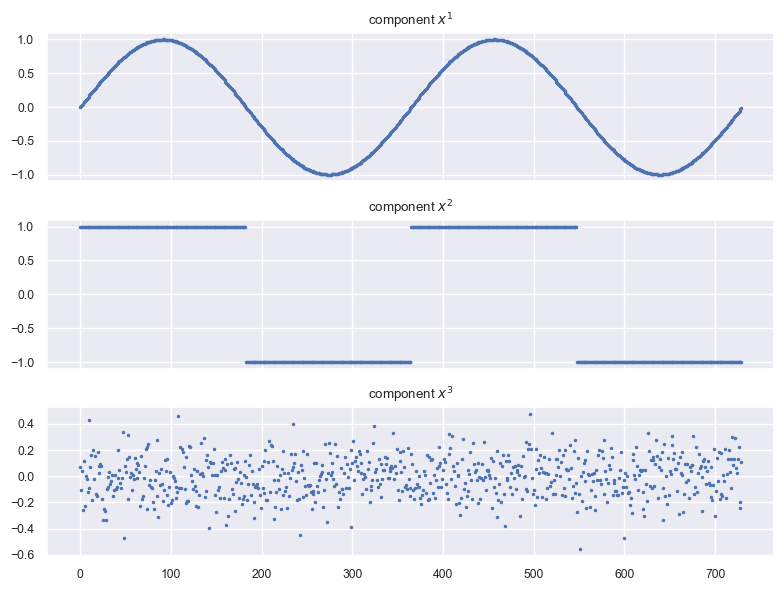

In [3]:
plot_decomp(X_real)

In [4]:
# Create DF
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

# Take signal <365 for first few tests
signal_365 = test_df["test_signal"].array[:365]
X_real_365 = [x[:365] for x in X_real]

## Note: 
For this function, adjusted c1 from 10 (default) to 2 

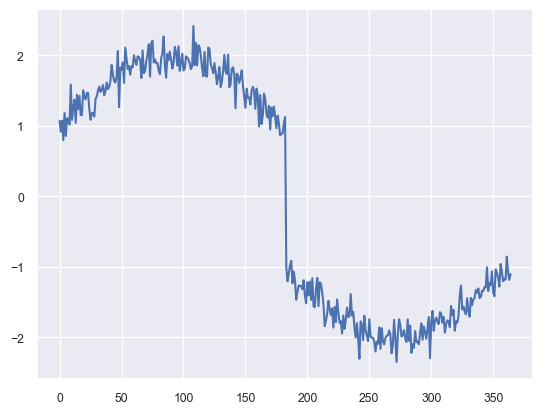

In [5]:
plt.plot(signal_365);

### Default

In [6]:
s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365"] + ["expected_s_seas_mosek_365"] + ["expected_obj_val_mosek_365"]

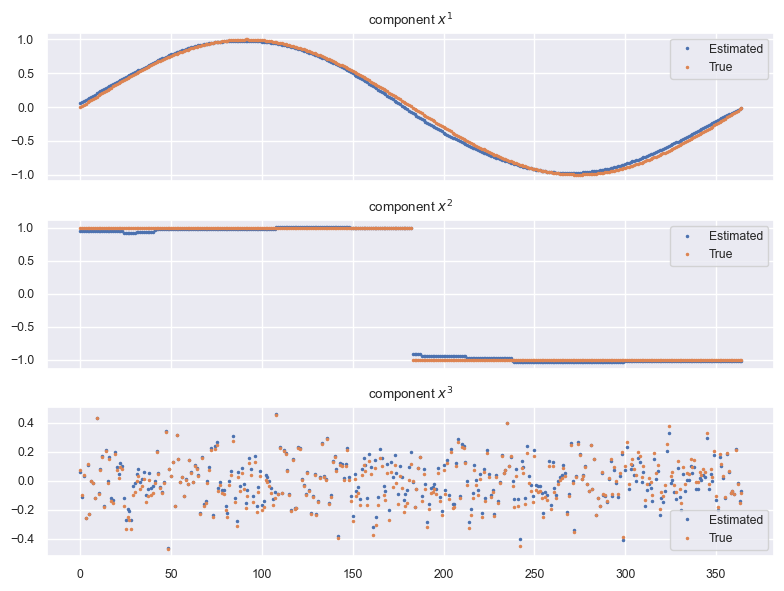

In [7]:
plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ tv_weights

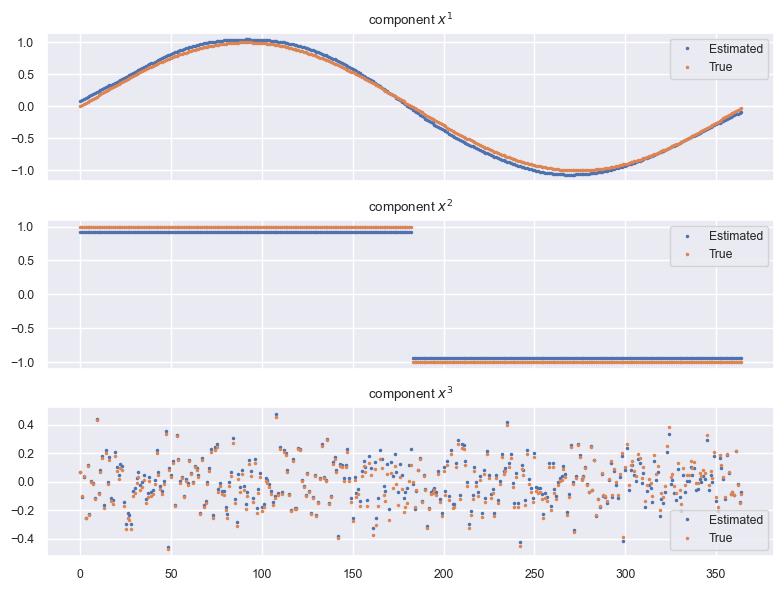

In [8]:
# Generate random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(rand_residual_weights), pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

# Pass tv_weights to function
s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", return_obj=True, 
                                             tv_weights=test_df["rand_tv_weights_365"].dropna())
# Add results to DF
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat),  pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365", "expected_s_seas_mosek_tvw_365", "expected_obj_val_mosek_tvw_365"]

plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ residual_weights

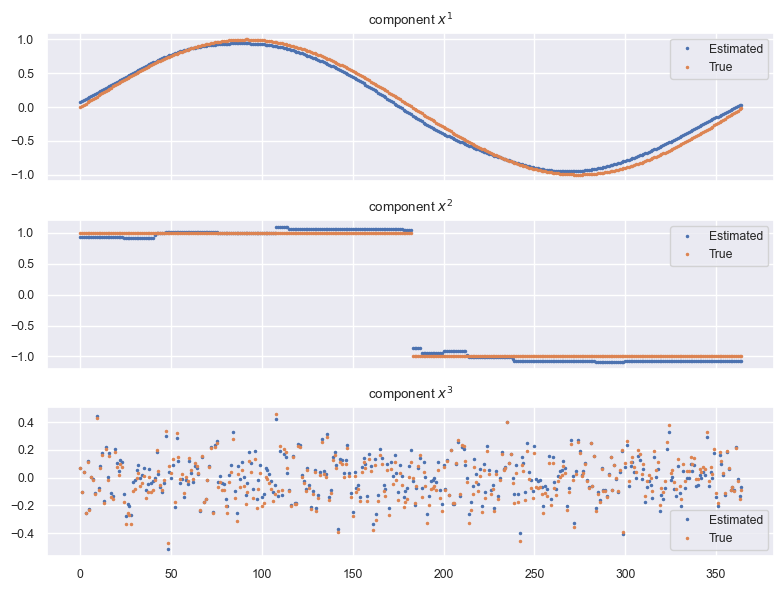

In [9]:
# Pass residual weights to function
s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", return_obj=True, 
                                             residual_weights=test_df["rand_residual_weights_365"].dropna())
# Add results to DF
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat),  pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", "expected_s_seas_mosek_rw_365", "expected_obj_val_mosek_rw_365"]

plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ transition pnt

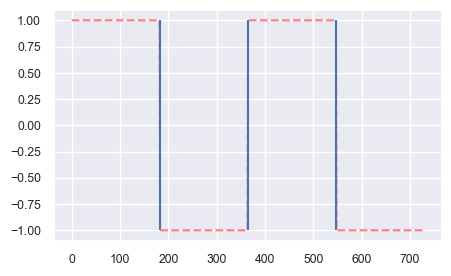

In [10]:
# get indices of piecewise fn transitions
plt.figure(figsize=(5,3))
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.vlines(182, -1, 1)
plt.vlines(364, -1, 1)
plt.vlines(547, -1, 1);

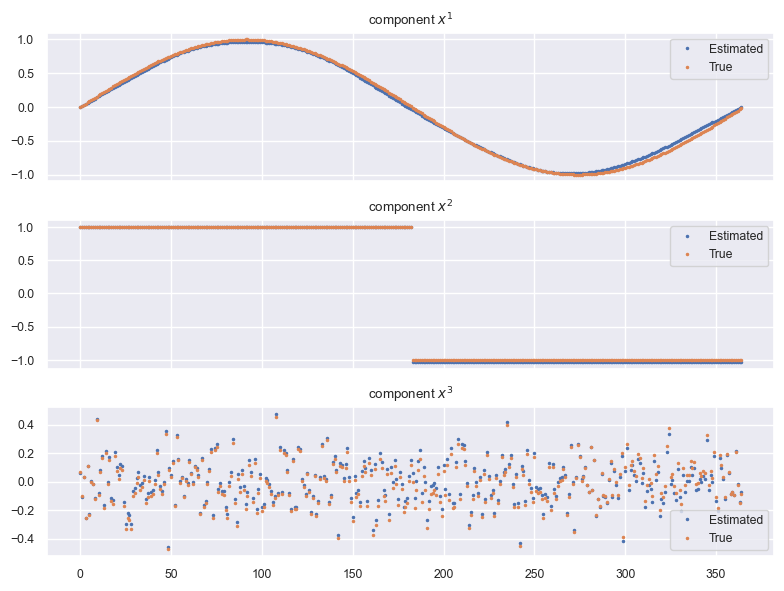

In [11]:
idx = [182] # only up to index 365 since not taking the full signal in this test (len(signal)<365)

s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx, return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_365", 
                                "expected_s_seas_mosek_transition_365",
                                "expected_obj_val_mosek_transition_365"]
plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ wrong transition indices

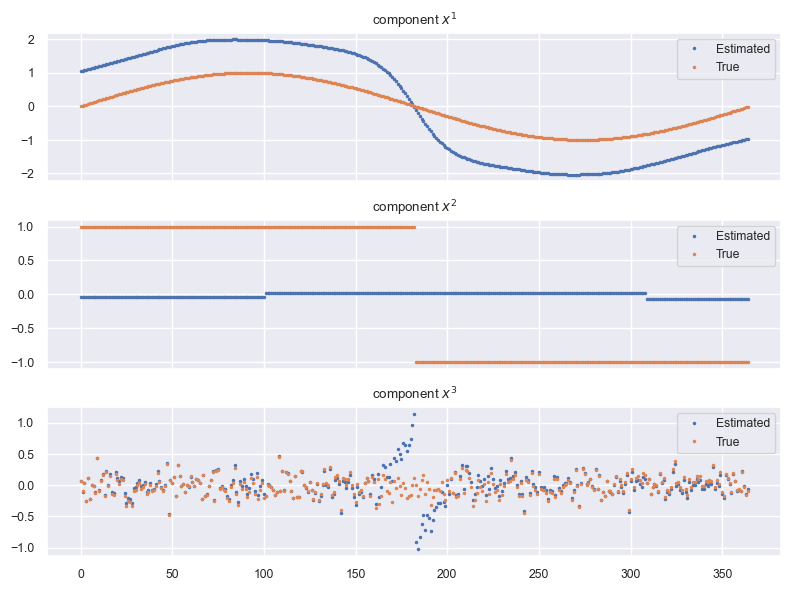

In [12]:
idx_wrong = [100, 308] # random 

s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx_wrong, return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_wrong_365",
                                "expected_s_seas_mosek_transition_wrong_365",
                                "expected_obj_val_mosek_transition_wrong_365"
                               ]
plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ max seas constraint  

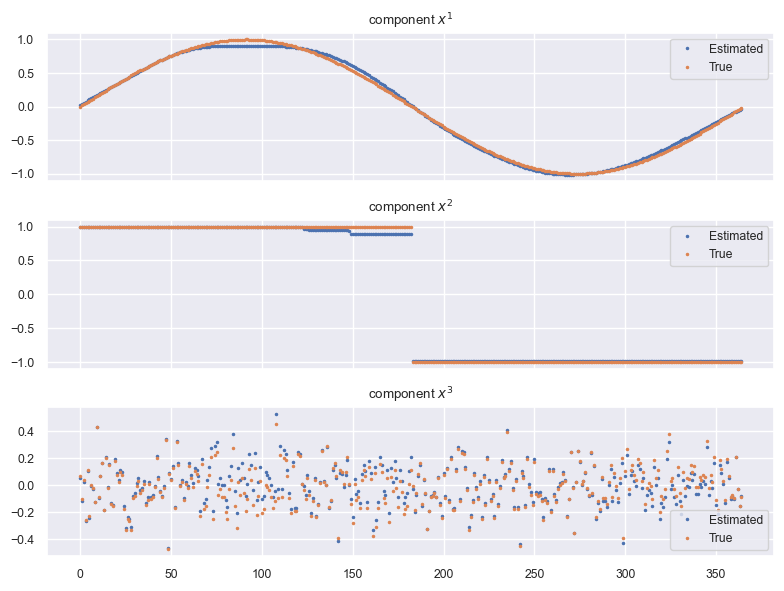

In [13]:
s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", seas_max=0.9, return_obj=True) # is this reasonable?

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_seas_max_365", "expected_s_seas_mosek_seas_max_365","expected_obj_val_mosek_seas_max_365"]

plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ signal w/ len > 365
### Default

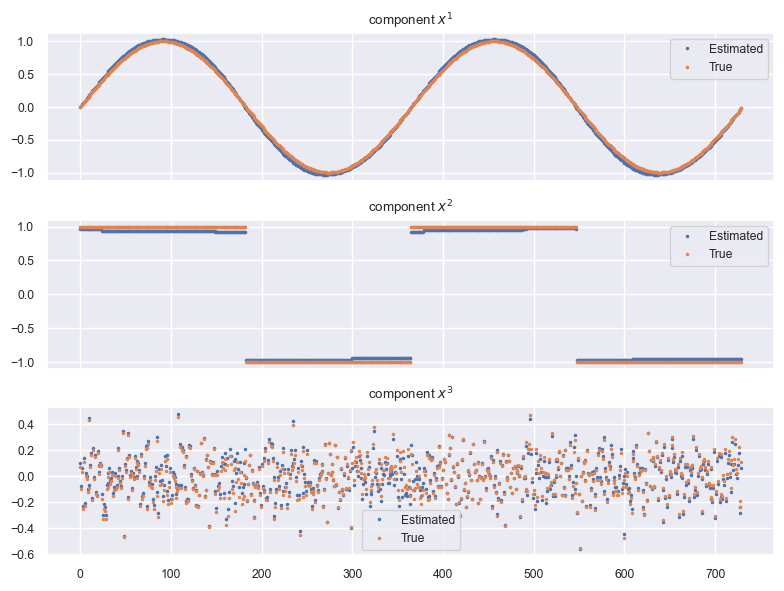

In [14]:
signal_730 = test_df["test_signal"].array

s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", return_obj=True)
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas
test_df["expected_obj_val_mosek"] = obj_val

plot_decomp([s_seas, s_hat, s_error], X_real)

### W/ select indices 

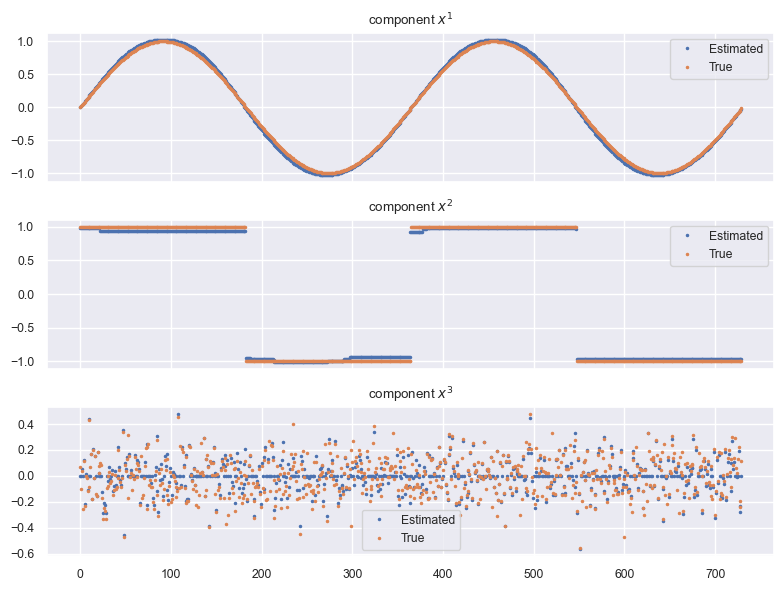

In [15]:
# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

# MOSEK
s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val
test_df["indices"] = indices

plot_decomp([s_seas, s_hat, s_error], X_real)

### Yearly periodic

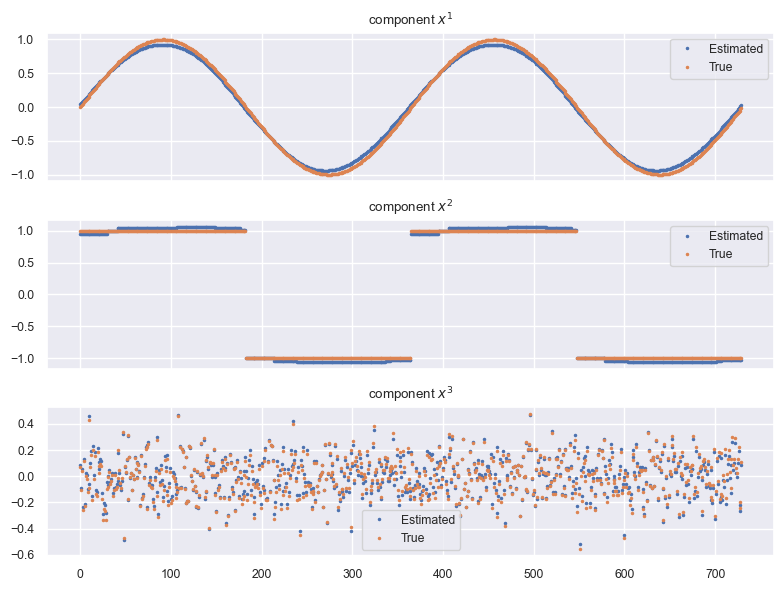

In [16]:
# yearly periodic constraint, len has to be >365
s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(signal_730,  c1=1, solver = "MOSEK", yearly_periodic=True, return_obj=True)
test_df["expected_s_hat_mosek_yearly_periodic"] = s_hat
test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

plot_decomp([s_seas, s_hat, s_error], X_real)

## Save 

In [17]:
test_df = test_df.round(7)

fname = "test_l2_l1d1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

## `l1_l2d2p365`

Components:
- l1: laplacian noise, sum-of-absolute values or l1-norm
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests:
- test_l1_l2d2p365_default
- test_l1_l2d2p365_idx_select
- test_l1_l2d2p365_long_not_yearly_periodic

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import random

from utils import plot_decomp
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

In [2]:
t = np.arange(365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((2, len(t)), dtype=float)
# laplacian noise
signal2 = 0.15 * np.random.laplace(0, 1, len(signal1))

X_real[0] = signal1
X_real[1] = signal2

y = np.sum(X_real, axis=0)

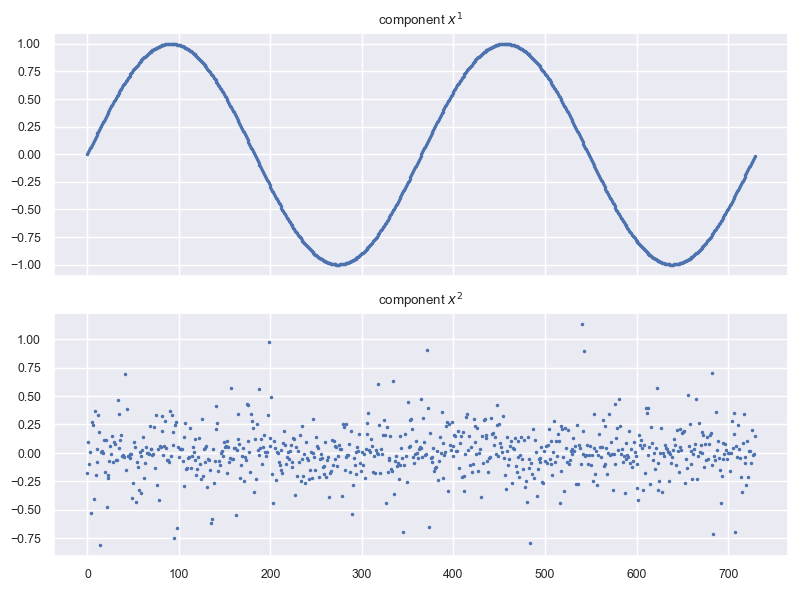

In [3]:
plot_decomp(X_real)

In [4]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
# take signal <365
signal_365 = test_df["test_signal"].array[:365]
X_real_365 = [x[:365] for x in X_real]

### Default

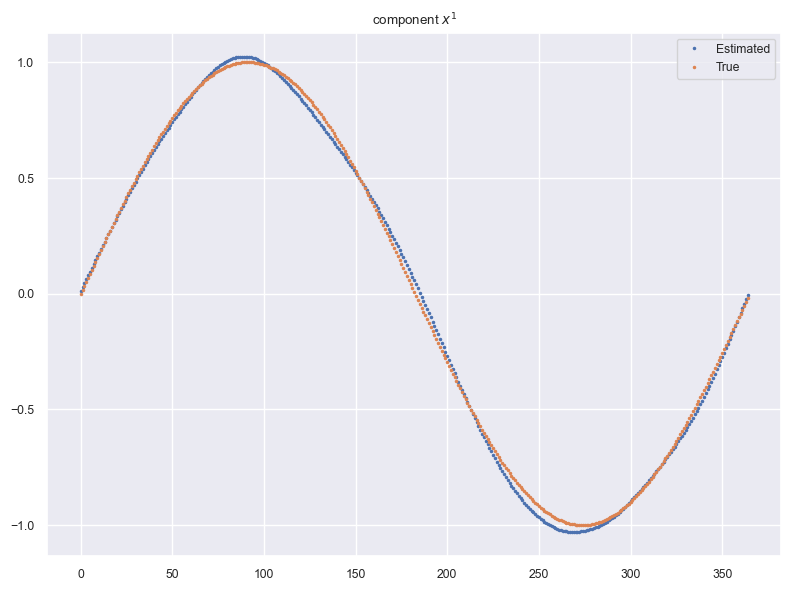

In [5]:
s_seas, obj_val = sd.l1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365", "expected_obj_val_mosek_365"]

plot_decomp([s_seas], [X_real_365[0]])

### W/ select indices 

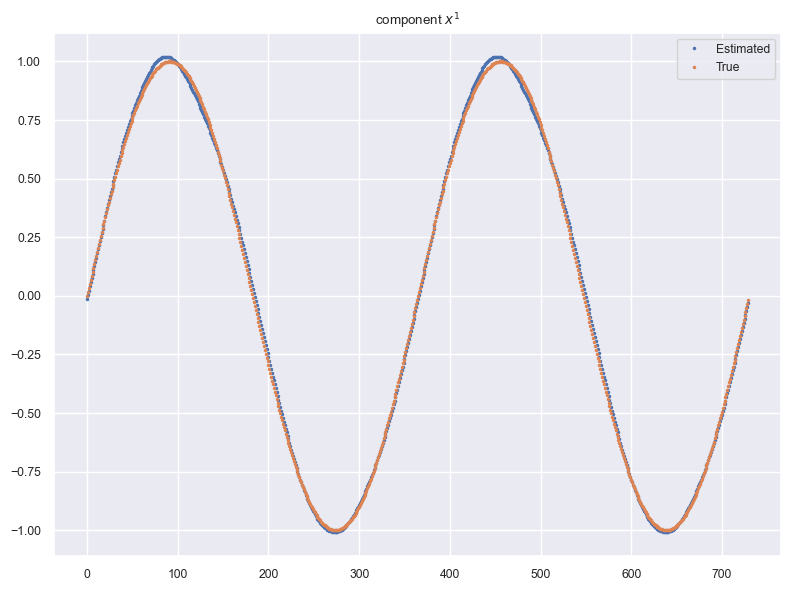

In [6]:
# take full signal
signal_730 = test_df["test_signal"].array

# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

s_seas, obj_val = sd.l1_l2d2p365(signal_730, solver = "MOSEK", c1=1000, use_ixs=indices, return_obj=True)
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val
test_df["indices"] = indices

plot_decomp([s_seas], [X_real[0]])

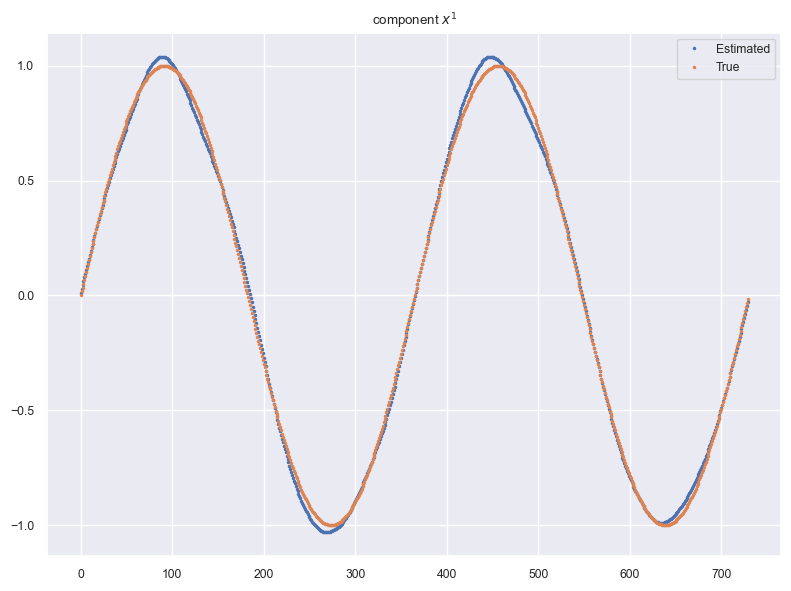

In [7]:
# yearly periodic = False (default is True) and >365
s_seas, obj_val = sd.l1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=False, return_obj=True)

test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

plot_decomp([s_seas], [X_real[0]])

## Save

In [8]:
test_df = test_df.round(7)
fname = "test_l1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

## `tl1_l2d2p365`

Components:
- tl1: 'tilted l1-norm,' also known as quantile cost function
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests:
- test_tl1_l2d2p365_default
- test_tl1_l2d2p365_idx_select
- test_tl1_l2d2p365_long_not_yearly_periodic

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import laplace_asymmetric
import random

from utils import plot_decomp
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

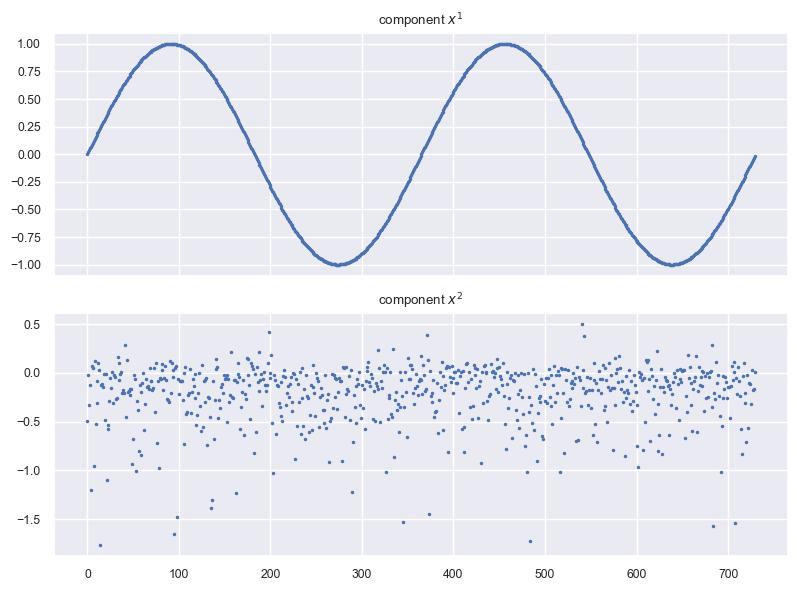

In [3]:
t = np.arange(365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# asymmetric laplacian noise
kappa = 2 # k>0, k=1 is laplace
signal2 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2

y = np.sum(X_real, axis=0)
plot_decomp(X_real)

In [4]:
# Take signal<365
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
signal_365 = test_df["test_signal"].array[:365]
X_real_365 = [x[:365] for x in X_real]

### Default

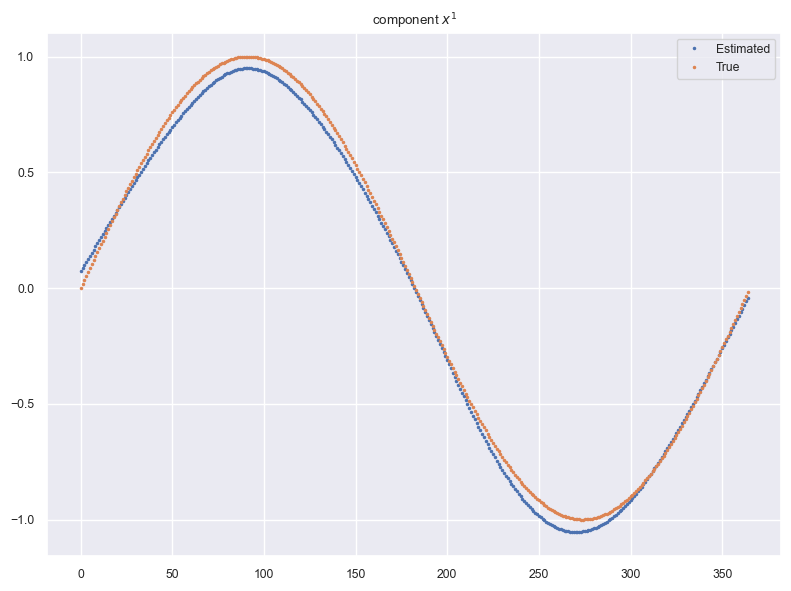

In [8]:
s_seas, obj_val = sd.tl1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365", "expected_obj_val_mosek_365"]

plot_decomp([s_seas], [X_real_365[0]])

### W/ select indices

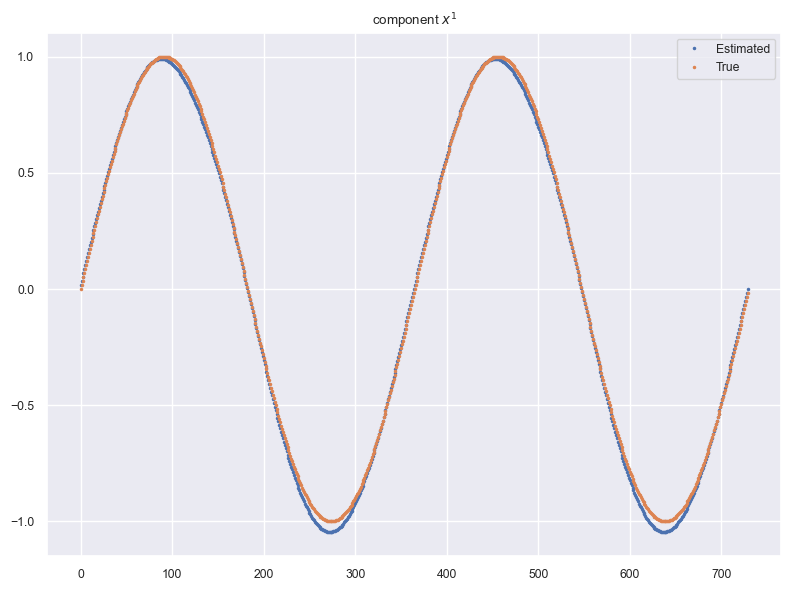

In [5]:
# take full signal
signal_730 = test_df["test_signal"].array

# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

s_seas, obj_val = sd.tl1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val
test_df["indices"] = indices

plot_decomp([s_seas], [X_real[0]])

### not yearly periodic

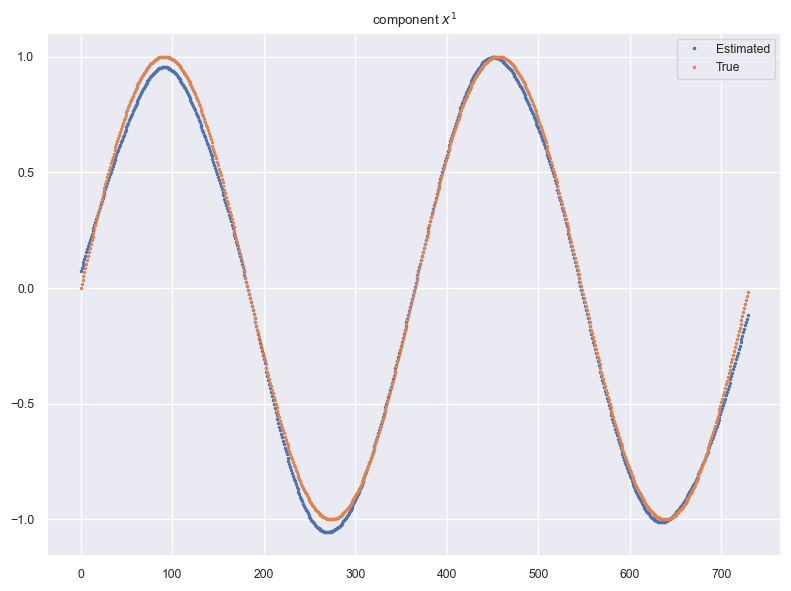

In [6]:
# yearly periodic and >365
s_seas, obj_val = sd.tl1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=False, return_obj=True)

test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

plot_decomp([s_seas], [X_real[0]])

## Save

In [9]:
test_df = test_df.round(7)
fname = "test_tl1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

## `tl1_l1d1_l2d2p365`

Components:
- tl1: 'tilted l1-norm,' also known as quantile cost function
- l1d1: piecewise constant heuristic, l1-norm of first order differences
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests:
- test_tl1_l1d1_l2d2p365_default
- test_tl1_l1d1_l2d2p365_idx_select
- test_tl1_l1d1_l2d2p365_tv_weights
- test_tl1_l1d1_l2d2p365_residual_weights

In [20]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import laplace_asymmetric
import random

from utils import plot_decomp
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

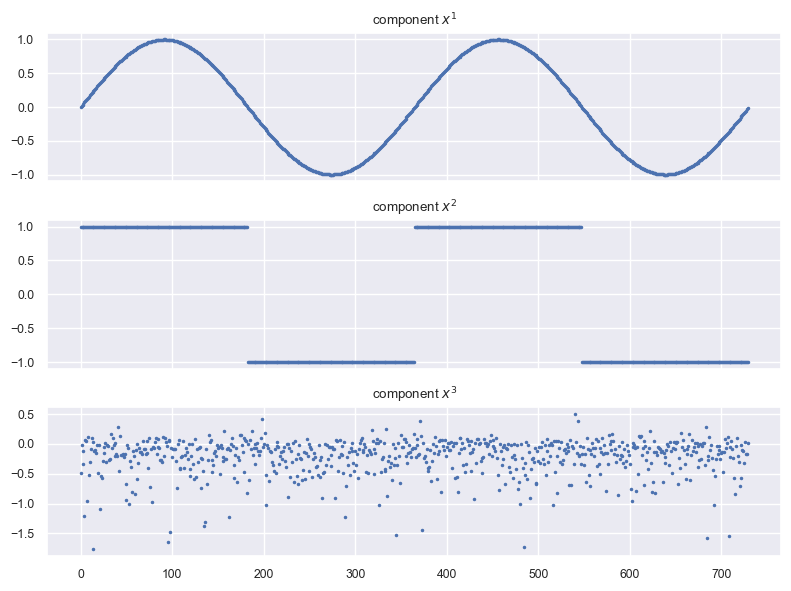

In [2]:
t = np.arange(365*2)

# seasonal term
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# piecewise constant term
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
# asymmetric laplace noise 
kappa = 2 # k>0, k=1 is laplace
signal3 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

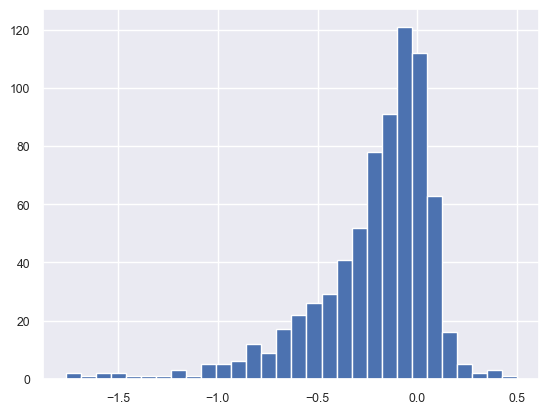

In [3]:
plt.hist(signal3, bins=30);

In [4]:
np.quantile(signal3, .8)

0.006092775222533824

In [5]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
signal_365 = test_df["test_signal"].array[:365]
X_real_365 = [x[:365] for x in X_real]

### Default

### Note:
- tau changed from 0.995 to 0.8
- c1 changed from 1000 to 5
- c2 from 100 to 500

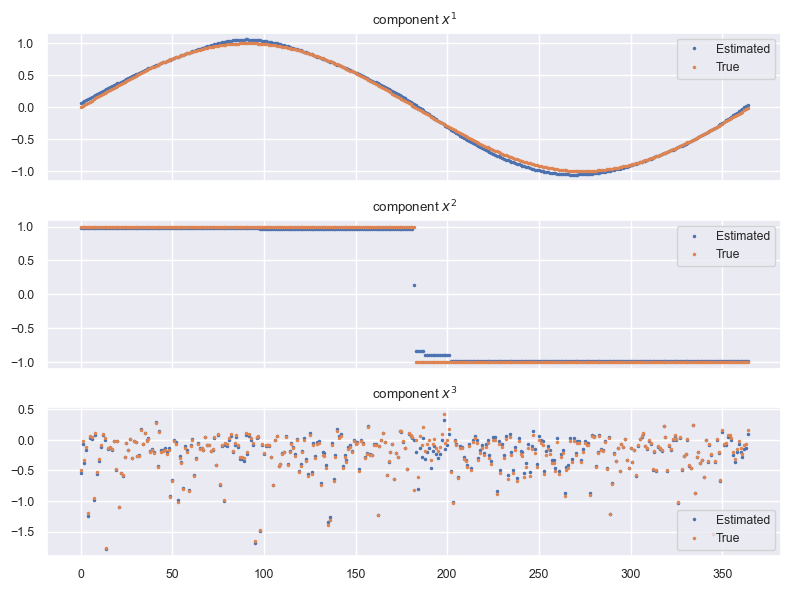

In [6]:
# c1 is tilted l1 param
s_hat, s_seas, s_error, s_linear, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, tau=0.8, c1=5, c2=500, c3=100, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365", "expected_s_seas_mosek_365", "expected_obj_val_mosek_365"]

plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ select indices 

### Note
- tau changed from 0.995 to 0.8
- c1 changed from 1000 to 5
- c2 changed from 100 to 500

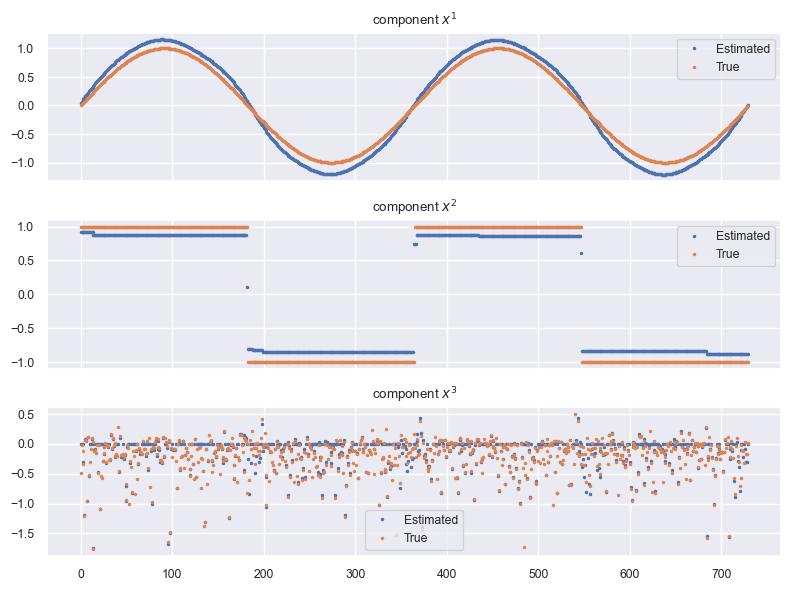

In [7]:
# take full signal
signal_730 = test_df["test_signal"].array

# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

s_hat, s_seas, s_error, _, obj_val = sd.tl1_l1d1_l2d2p365(signal_730, solver = "MOSEK", tau=0.8, c1=5, c2=500, use_ixs=indices, return_obj=True)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val
test_df["indices"] = indices

plot_decomp([s_seas, s_hat, s_error], X_real)

### W/ residual_weights

In [8]:
# random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(rand_residual_weights), pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

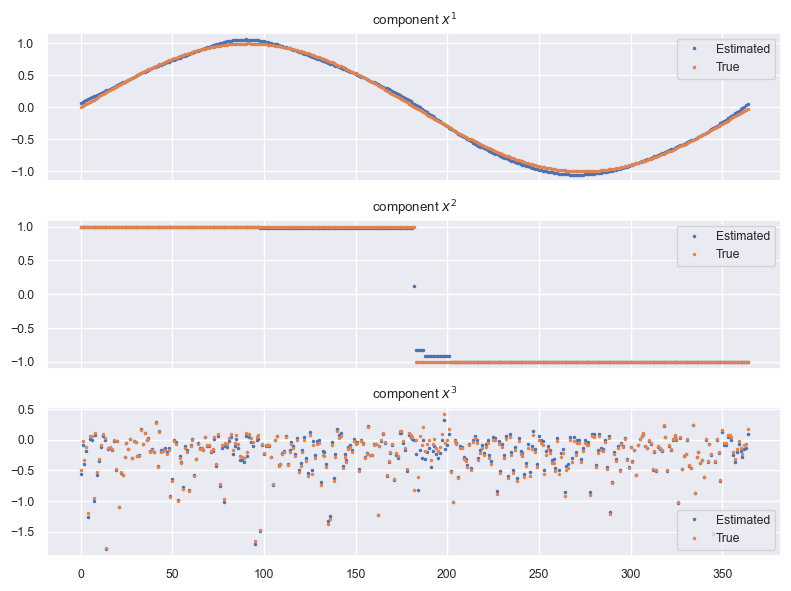

In [10]:
s_hat, s_seas, s_error, _, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, 
                                                          tau=0.8,
                                                          c1=5,
                                                          c2=500,
                                                          solver = "MOSEK",
                                                          return_obj=True, 
                                                          residual_weights=test_df["rand_residual_weights_365"].dropna()
                                                         )

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", "expected_s_seas_mosek_rw_365", "expected_obj_val_mosek_rw_365"]

plot_decomp([s_seas, s_hat, s_error], X_real_365)

### W/ tv_weights

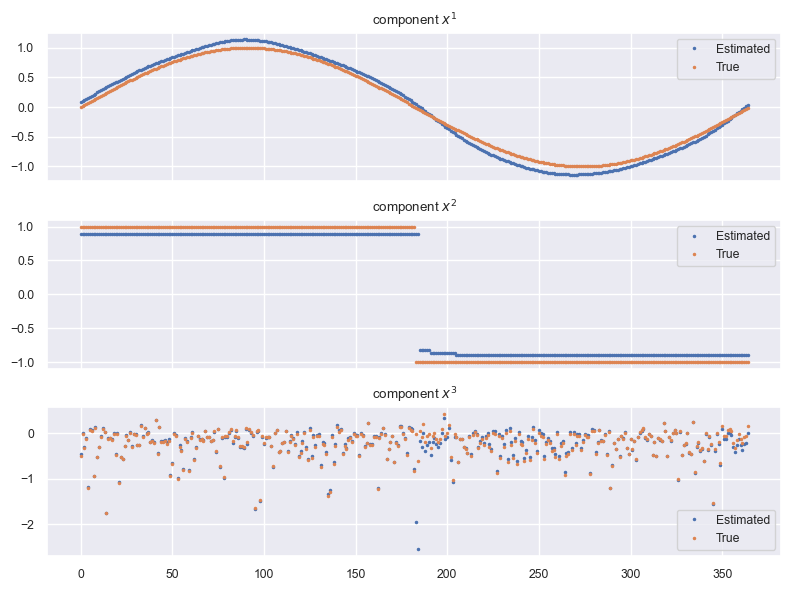

In [12]:
s_hat, s_seas, s_error, _, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, 
                                              tau=0.8,
                                              c1=5,
                                              c2=500,
                                              solver = "MOSEK",
                                              return_obj=True,
                                              tv_weights=test_df["rand_tv_weights_365"].dropna()
                                                         )
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365", "expected_s_seas_mosek_tvw_365", "expected_obj_val_mosek_tvw_365"]

plot_decomp([s_seas, s_hat, s_error], X_real_365)

## Save

In [14]:
test_df = test_df.round(7)
fname = "test_tl1_l1d1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')